###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Deformed Cartesian quad meshes by transfinite interpolation

As we have seen in the previous lesson, the equidistant Cartesian grid has some serious limitations when an accurate approximation of layer interfaces is required. One possible solution are deformed Cartesian quad meshes, which are commonly used in the framework of the Spectral Element Method which we will cover in a later lecture. I want to illustrate this problem using an example I'm currently working on.

## Problem: Sea Dike with strong topography

I have applied Full Waveform Inversion (FWI) to SH-data acquired on a sea dike at the west coast of Schleswig-Holstein in Northern Germany ([Köhn et al. 2018](https://www.researchgate.net/publication/324138422_Sea_dike_evaluation_by_SH_full_waveform_inversion)). To avoid problems with the Cartesian-grid discretization of the free-surface with strong topography used in the finite-difference forward modelling code, the model and acquisition geometry are rotated according to the topography and the FWI applied to a model with planar free surface. Finally, the FWI results are rotated back relative to the true sea dike topography. The resulting Vs-model shows some high- and low-velocity layers (Fig. 1), which can be related to sand and marine clay layers verified by borehole-profiles.

<img src="images/tumlauk_deich_FWI.jpg" width="90%">

*Fig. 1 FWI results for the land- and sea-side of the Tümlauer Koog sea dike (from [Köhn et al. 2018](https://www.researchgate.net/publication/324138422_Sea_dike_evaluation_by_SH_full_waveform_inversion)).*

This approach has the disadvantage, that we can not use the full dataset acquired over the full length of the dike, but have to restrict the FWI to sources and receivers on the tilted surfaces of the dike. Therefore, we want to replace the finite difference by a spectral element forward modelling engine, which can handle a model discretization using regular deformed quad meshes.

## Transfinite Interpolation 

We want to map a Cartesian mesh defined on a unit sqare in the logical domain $(\xi,\eta)$ to the physical domain $(x,z)$, where the Cartesian mesh is deformed:

<img src="images/TFI_concept.png" width="100%">

The deformation of the mesh is described by the boundary curves $\vec{x}_t$, $\vec{x}_b$, $\vec{x}_l$ and $\vec{x}_r$. To calculate the deformed quad cells inside the physical domain we can use **Transfinite Interpolation (TFI)**. TFI was introduced by ([Gordon and Hall, 1973 ](https://onlinelibrary.wiley.com/doi/abs/10.1002/nme.1620070405)) which uses the first degree **Lagrange polynomials** $1-\xi$, $\xi$, $1-\eta$ and $\eta$ as blending functions in the basic transfinite interpolation formula:

\begin{align}
\vec{x}(\xi,\eta) & = (1-\eta)\vec{x}_b(\xi) + \eta \vec{x}_t(\xi) + (1-\xi)\vec{x}_l(\eta)+\xi\vec{x}_r(\eta)\nonumber\\
&-\{\xi\eta\vec{x}_t(1)+\xi(1-\eta)\vec{x}_b(1)\nonumber\\
&+\eta(1-\xi)\vec{x}_t(0)+(1-\xi)(1-\eta)\vec{x}_b(0),\nonumber
\end{align}

with $\vec{x}=(x,z)$. For more details, I refer to the book [The Fundamentals of Grid Generation](https://www.researchgate.net/publication/265361548_The_Fundamentals_of_Grid_Generation) by Patrick M. Knupp and Stanly Steinberg. Let's try to reproduce an example from the book denoted as "The Swan". 

In [2]:
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Here, I introduce a new library, which is useful 
# to define the fonts and size of a figure in a notebook
from pylab import rcParams

# Get rid of a Matplotlib deprecation warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define parameters for deformed Cartesian mesh
NX = 20
NZ = 20

In [4]:
# Define parametric curves at model boundaries ...
# ... bottom boundary
def Xb(s):
    
    x = s
    z = 0.0

    xzb = [x,z]
    
    return xzb

# ... top boundary
def Xt(s):
    
    x = s
    z = 1 - 3 * s + 3 * s**2    

    xzt = [x,z]
    
    return xzt

# ... left boundary
def Xl(s):
    
    x = 0.0
    z = s  

    xzl = [x,z]
    
    return xzl

# ... right boundary
def Xr(s):
    
    x = 1 + 2 * s - 2 * s**2
    z = s
    
    xzr = [x,z]
    
    return xzr

In [5]:
# Transfinite interpolation

# Discretize along xi and eta axis
xi = np.linspace(0.0, 1.0, num=NX)
eta = np.linspace(0.0, 1.0, num=NZ)

xi1, eta1 = np.meshgrid(xi, eta)

# Intialize matrices for x and z axis
X = np.zeros((NX,NZ))
Z = np.zeros((NX,NZ))

# loop over cells
for i in range(NX):
    Xi = xi[i]
    for j in range(NZ):
        Eta = eta[j]
        
        # evaluate parametric curves
        xb = Xb(Xi)
        xb0 = Xb(0)
        xb1 = Xb(1)
        
        xt = Xt(Xi)
        xt0 = Xt(0)
        xt1 = Xt(1)
        
        xl = Xl(Eta)
        xr = Xr(Eta)

        # Transfinite Interpolation (Gordon-Hall algorithm)
        X[i,j] = (1-Eta) * xb[0] + Eta * xt[0] + (1-Xi) * xl[0] + Xi * xr[0] \
               - (Xi * Eta * xt1[0] + Xi * (1-Eta) * xb1[0] + Eta * (1-Xi) * xt0[0] \
               + (1-Xi) * (1-Eta) * xb0[0])
            
        Z[i,j] = (1-Eta) * xb[1] + Eta * xt[1] + (1-Xi) * xl[1] + Xi * xr[1] \
               - (Xi * Eta * xt1[1] + Xi * (1-Eta) * xb1[1] + Eta * (1-Xi) * xt0[1] \
               + (1-Xi) * (1-Eta) * xb0[1])        

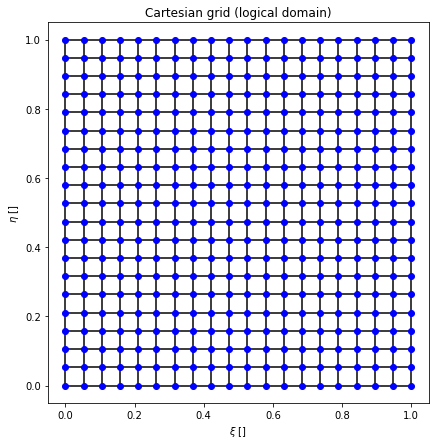

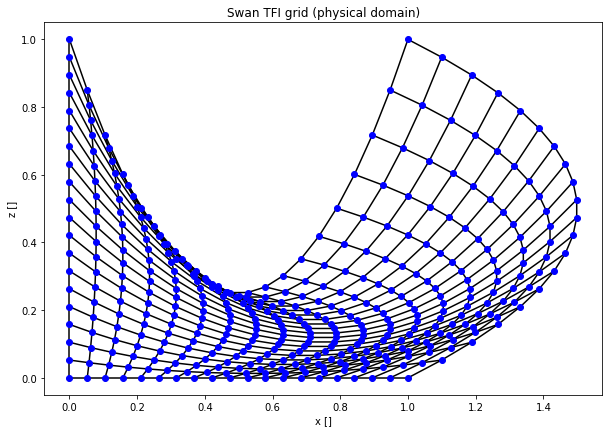

In [6]:
# Define figure size
rcParams['figure.figsize'] = 10, 7

# Plot TFI mesh (physical domain)
plt.plot(xi1, eta1, 'k')
plt.plot(xi1.T, eta1.T, 'k')

# Plot grid points
plt.plot(xi1, eta1, 'bo')

plt.title("Cartesian grid (logical domain)" )
plt.xlabel(r"$\xi$ []")
plt.ylabel(r"$\eta$ []")
plt.axes().set_aspect('equal')
plt.show()

# Plot TFI mesh (physical domain)
plt.plot(X, Z, 'k')
plt.plot(X.T, Z.T, 'k')

# Plot grid points
plt.plot(X, Z, 'bo')

plt.title("Swan TFI grid (physical domain)" )
plt.xlabel("x []")
plt.ylabel("z []")
plt.axes().set_aspect('equal')
#plt.savefig('vp_sine1.pdf', bbox_inches='tight', format='pdf')
plt.show()

The implemented TFI seem to work correctly, so we can take a look at the sea dike problem in the next lesson.

## We learned:

* A rough idea how a Cartesian mesh can be deformed by TFI
* How to implement TFI
* How to fold a Cartesian mesh to a digital swan. Folding of an analog swan is described [here](http://www.origami-instructions.com/origami-swan.html)